In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import os

In [2]:
yf.pdr_override()

In [3]:
start_date = '{}-01-01'.format(date.today().year - 1)
end_date = (datetime.now() + timedelta(1)).strftime("%Y-%m-%d")

In [4]:
now = datetime.now()
monday = (now - timedelta(days = now.weekday())).strftime("%Y-%m-%d")

In [5]:
def first_business_day(date):
#     if date.day > 25:
#         date += timedelta(7)
    month = date.replace(day=1)
    if month.weekday() > 4:
        month = date.replace(day=(8 - month.weekday()))
    return month.strftime("%Y-%m-%d")

In [6]:
month = first_business_day(date.today())
three_month = first_business_day((date.today() + relativedelta(months=-3)))
six_month = first_business_day((date.today() + relativedelta(months=-6)))

In [7]:
month = '2020-11-03'

In [8]:
def get_kpi_value(ticket, kpi):
    file = './crawlers/{}.json'.format(ticket)
    if os.path.exists(file):
        try:
            kpis = pd.read_json(file)
            return float(kpis[kpis['title'] == kpi]['value'].values[0].replace('.', '').replace(',', '.'))
        except:
            return 0
    return 0

In [9]:
def sector_kpi(tickets, kpi):
    kpis = []
    for ticket in tickets:
        ticket = ticket.replace('.SA', '')
        kpis.append(get_kpi_value(ticket, kpi))
    kpis_len = len([i for i in kpis if i > 0])
    if kpis_len > 0:
        return sum(kpis) / kpis_len
    return 0

In [14]:
def generate_json(empresas, indicador, arquivo):
    setores = {}
    for i in empresas[['Setor', 'Código Yahoo']].iterrows():
        setor = i[1]['Setor']
        codigo = i[1]['Código Yahoo']
        if setor not in setores:
            setores[setor] = []
        lista = setores[setor]
        lista.append(codigo)
        setores[setor] = lista
        
    val_indicador = pdr.get_data_yahoo(indicator, start=start_date, end=end_date)
    data = pdr.get_data_yahoo(list(empresas['Código Yahoo']), start=start_date, end=end_date)
    
    df_categories = pd.DataFrame()
    df_open = pd.DataFrame()
    df_mean = pd.DataFrame()
    df_indicators = pd.DataFrame()
    
    for setor in setores.keys():
        df_categories[setor] = data['Close'][setores[setor]].mean(axis=1)
        df_open[setor] = data['Open'][setores[setor]].mean(axis=1)
    df_categories[indicador] = val_indicador['Close']
    df_open[indicador] = val_indicador['Open']
    df_categories.fillna(method='ffill', inplace=True)
    df_open.fillna(method='ffill', inplace=True)
    
    setores[indicador] = [indicador]
    
    for setor in setores.keys():
        valor_ano = round(df_categories.iloc[0][setor], 2)
        valor_seis_meses = round(df_categories.iloc[df_categories.index.get_loc(six_month,method='nearest')][setor], 2)
        valor_tres_meses = round(df_categories.iloc[df_categories.index.get_loc(three_month,method='nearest')][setor], 2)
        valor_mes = round(df_categories.loc[month][setor], 2)
        valor_semana = round(df_categories.loc[monday][setor], 2)
        valor_ontem = round(df_open.iloc[-1][setor], 2)
        valor_hoje = round(df_categories.iloc[-1][setor], 2)

        percent_ano = round((((valor_hoje - valor_ano) / valor_ano) * 100), 2)
        percent_seis_meses = round((((valor_hoje - valor_seis_meses) / valor_seis_meses) * 100), 2)
        percent_tres_meses = round((((valor_hoje - valor_tres_meses) / valor_tres_meses) * 100), 2)
        percent_mes = round((((valor_hoje - valor_mes) / valor_mes) * 100), 2)
        percent_semana = round((((valor_hoje - valor_semana) / valor_semana) * 100), 2)
        percent_hoje = round((((valor_hoje - valor_ontem) / valor_ontem) * 100), 2)
        
        pvp = round(sector_kpi(setores[setor], 'P/VP'), 2)
        
        line = pd.Series({
            'inicio_ano': valor_ano,
            'inicio_seis_meses': valor_seis_meses,
            'inicio_tres_meses': valor_tres_meses,
            'inicio_mes': valor_mes,
            'inicio_semana': valor_semana,
            'hoje': valor_hoje,
            'percent_ano': percent_ano,
            'percent_seis_meses': percent_seis_meses,
            'percent_tres_meses': percent_tres_meses,
            'percent_mes': percent_mes,
            'percent_semana': percent_semana,
            'percent_hoje': percent_hoje,
            'P/VP': pvp
        }, name=setor)
        df_mean = df_mean.append(line)
        
    df_mean.T.to_json('dashboard/src/' + arquivo)

In [15]:
# https://blog.toroinvestimentos.com.br/empresas-listadas-b3-bovespa
empresas_ibov = pd.read_csv('empresas.csv', sep=';')
empresas_ibov['Código Yahoo'] = empresas_ibov['Código'].apply(lambda x: x + '.SA')
indicator = '^BVSP'
file = 'ibov.json'
generate_json(empresas_ibov, indicator, file)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  66 of 66 completed

1 Failed download:
- PCAR4.SA: No data found, symbol may be delisted


In [16]:
empresas_ibov = pd.read_csv('empresas_b3.csv', sep=';', encoding = "ISO-8859-1")
indicator = '^BVSP'
file = 'b3.json'
#empresas_ibov = empresas_ibov[empresas_ibov['Código Yahoo'].str.contains("\.SA")]
generate_json(empresas_ibov, indicator, file)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  291 of 291 completed


In [17]:
empresas_ibov = pd.read_json('ifix.json')
empresas_ibov['Código Yahoo'] = empresas_ibov['Código'].apply(lambda x: x + '.SA')
indicator = 'IFIX.SA'
file = 'ifix.json'
generate_json(empresas_ibov, indicator, file)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  119 of 119 completed


In [9]:
for i in empresas_ibov[['Setor', 'Código Yahoo']].iterrows():
    setor = i[1]['Setor']
    codigo = i[1]['Código Yahoo']
    if setor not in setores:
        setores[setor] = []
    lista = setores[setor]
    lista.append(codigo)
    setores[setor] = lista

In [10]:
bova11 = pdr.get_data_yahoo(indicator, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [11]:
data = pdr.get_data_yahoo(list(empresas_ibov['Código Yahoo']), start=start_date, end=end_date)

[*********************100%***********************]  119 of 119 completed


In [15]:
df_categories = pd.DataFrame()
df_mean = pd.DataFrame()
df_indicators = pd.DataFrame()

In [16]:
bova11['Close']

Date
2019-01-02    87.900002
2019-01-03    88.000000
2019-01-04    88.500000
2019-01-07    88.480003
2019-01-08    88.830002
                ...    
2020-08-28    98.300003
2020-08-31    96.250000
2020-09-01    98.300003
2020-09-02    98.099998
2020-09-03    96.959999
Name: Close, Length: 413, dtype: float64

In [17]:
df_indicators

""


In [18]:
for codigo in empresas_ibov['Código']:
    try:
        empresa = pd.read_json('crawlers/{}.json'.format(codigo))
        series = pd.Series(dict(zip(empresa['title'], empresa['value'])), name=codigo)
        df_indicators = df_indicators.append(series)
    except:
        print('Error loading {}'.format(codigo))

Error loading BRAP4
Error loading BRKM5
Error loading CMIG4
Error loading ELET6
Error loading GGBR4
Error loading GOAU4
Error loading ITSA4
Error loading ITUB4
Error loading KLBN11
Error loading LAME4
Error loading PCAR4
Error loading PETR4
Error loading SANB11
Error loading TAEE11
Error loading VIVT4
Error loading USIM5


In [19]:
for setor in setores.keys():
    df_categories[setor] = data['Close'][setores[setor]].mean(axis=1)
# df_categories['Média'] = data['Close'].mean(axis=1)
df_categories['BOVA11'] = bova11['Close']
df_categories.fillna(method='ffill', inplace=True)

In [20]:
setores['BOVA11'] = ['BOVA11']

In [21]:
for setor in setores.keys():
    valor_ano = round(df_categories.iloc[0][setor], 2)
    valor_seis_meses = round(df_categories.iloc[df_categories.index.get_loc(six_month,method='nearest')][setor], 2)
    valor_tres_meses = round(df_categories.iloc[df_categories.index.get_loc(three_month,method='nearest')][setor], 2)
    valor_mes = round(df_categories.loc[month][setor], 2)
    valor_semana = round(df_categories.loc[monday][setor], 2)
    valor_ontem = round(df_categories.iloc[-2][setor], 2)
    valor_hoje = round(df_categories.iloc[-1][setor], 2)
    
    percent_ano = round((((valor_hoje - valor_ano) / valor_ano) * 100), 2)
    percent_seis_meses = round((((valor_hoje - valor_seis_meses) / valor_seis_meses) * 100), 2)
    percent_tres_meses = round((((valor_hoje - valor_tres_meses) / valor_tres_meses) * 100), 2)
    percent_mes = round((((valor_hoje - valor_mes) / valor_mes) * 100), 2)
    percent_semana = round((((valor_hoje - valor_semana) / valor_semana) * 100), 2)
    percent_hoje = round((((valor_hoje - valor_ontem) / valor_ontem) * 100), 2)
    line = pd.Series({
        'inicio_ano': valor_ano,
        'inicio_seis_meses': valor_seis_meses,
        'inicio_tres_meses': valor_tres_meses,
        'inicio_mes': valor_mes,
        'inicio_semana': valor_semana,
        'hoje': valor_hoje,
        'percent_ano': percent_ano,
        'percent_seis_meses': percent_seis_meses,
        'percent_tres_meses': percent_tres_meses,
        'percent_mes': percent_mes,
        'percent_semana': percent_semana,
        'percent_hoje': percent_hoje
    }, name=setor)
    df_mean = df_mean.append(line)

In [22]:
df_mean.head()

,hoje,inicio_ano,inicio_mes,inicio_seis_meses,inicio_semana,inicio_tres_meses,percent_ano,percent_hoje,percent_mes,percent_seis_meses,percent_semana,percent_tres_meses
Consumo não-cíclico,31.44,49.46,31.76,29.77,30.83,25.29,-36.43,-1.26,-1.01,5.61,1.98,24.32
Bens Industriais,23.46,20.00,23.78,27.15,22.99,18.34,17.30,-1.10,-1.35,-13.59,2.04,27.92
Comércio,57.35,25.87,61.56,41.98,60.31,47.76,121.69,-5.41,-6.84,36.61,-4.91,20.08
Financeiro,25.35,30.61,25.23,30.74,24.67,22.38,-17.18,0.80,0.48,-17.53,2.76,13.27
Seguros,16.90,28.04,16.93,30.98,16.75,16.98,-39.73,-1.29,-0.18,-45.45,0.90,-0.47


In [29]:
line_width = 40
columns = 2
relatorios = []
for setor in setores:
    dados = {
        'Hoje': 'hoje',
        'Hoje %': 'percent_hoje',
        'Início Semana': 'inicio_semana',
        'Semana %': 'percent_semana',
        'Início Mês': 'inicio_mes',
        'Mês %': 'percent_mes',
        'Início 3 Meses': 'inicio_tres_meses',
        '3 Meses %': 'percent_tres_meses',
        'Início 6 Meses': 'inicio_seis_meses',
        '6 Meses %': 'percent_seis_meses',
        'Início Ano': 'inicio_ano',
        'Ano %': 'percent_ano',
    }
    
    linha = ''
    linha += '<div class="title">{}</div>\n'.format(setor)
    i = 0
    for dado in dados:
        i += 1
        linha += '<div class="value">{}: {}</div>'.format(dado, df_mean.loc[setor][dados[dado]]).center(int(line_width / columns))
        if i == columns:
            linha += '\n'
            i = 0
#     linha += '\n' + '=' * line_width + '\n'
    relatorios.append(linha)
#     linha = '=' * line_width + '\n\n'
#     linha += setor.center(line_width) + '\n'
#     i = 0
#     for dado in dados:
#         i += 1
#         linha += '{}: {}'.format(dado, df_mean.loc[setor][dados[dado]]).center(int(line_width / columns))
#         if i == columns:
#             linha += '\n'
#             i = 0
#     linha += '\n' + '=' * line_width + '\n'

In [30]:
for relatorio in relatorios:
    print('<div class="item">{}</div>\n'.format(relatorio.replace('\n', '<br>')))

<div class="item"><div class="title">Exploração, Refino e Distribuição</div><br><div class="value">Hoje: 25.91</div><div class="value">Hoje %: -2.3</div><br><div class="value">Início Semana: 26.67</div><div class="value">Semana %: -2.85</div><br><div class="value">Início Mês: 25.72</div><div class="value">Mês %: 0.74</div><br><div class="value">Início 3 Meses: 18.38</div><div class="value">3 Meses %: 40.97</div><br><div class="value">Início 6 Meses: 29.82</div><div class="value">6 Meses %: -13.11</div><br><div class="value">Início Ano: 18.67</div><div class="value">Ano %: 38.78</div><br></div>

<div class="item"><div class="title">Equipamentos e Serviços</div><br><div class="value">Hoje: 3.38</div><div class="value">Hoje %: 0.0</div><br><div class="value">Início Semana: 3.44</div><div class="value">Semana %: -1.74</div><br><div class="value">Início Mês: 3.4</div><div class="value">Mês %: -0.59</div><br><div class="value">Início 3 Meses: 2.31</div><div class="value">3 Meses %: 46.32</di

In [259]:
df_mean.to_json('mean.json')

In [20]:
df_mean.T.to_json('mean_t.json')

In [32]:
df_mean.T.to_json('dashboard/src/mean_t.json')

In [23]:
df_mean.T.to_json('dashboard/src/' + file)

In [45]:
base_setores = {}
for setor in setores.keys():
    base_setores[setor] = df_categories.iloc[0][setor]

In [204]:
df_diff_categories = pd.DataFrame()
for setor in setores.keys():
    mean = data['Close'][setores[setor]].mean(axis=1)
    base_value = base_setores[setor]
    df_diff_categories[setor] = ((mean - base_value) / base_value) * 100

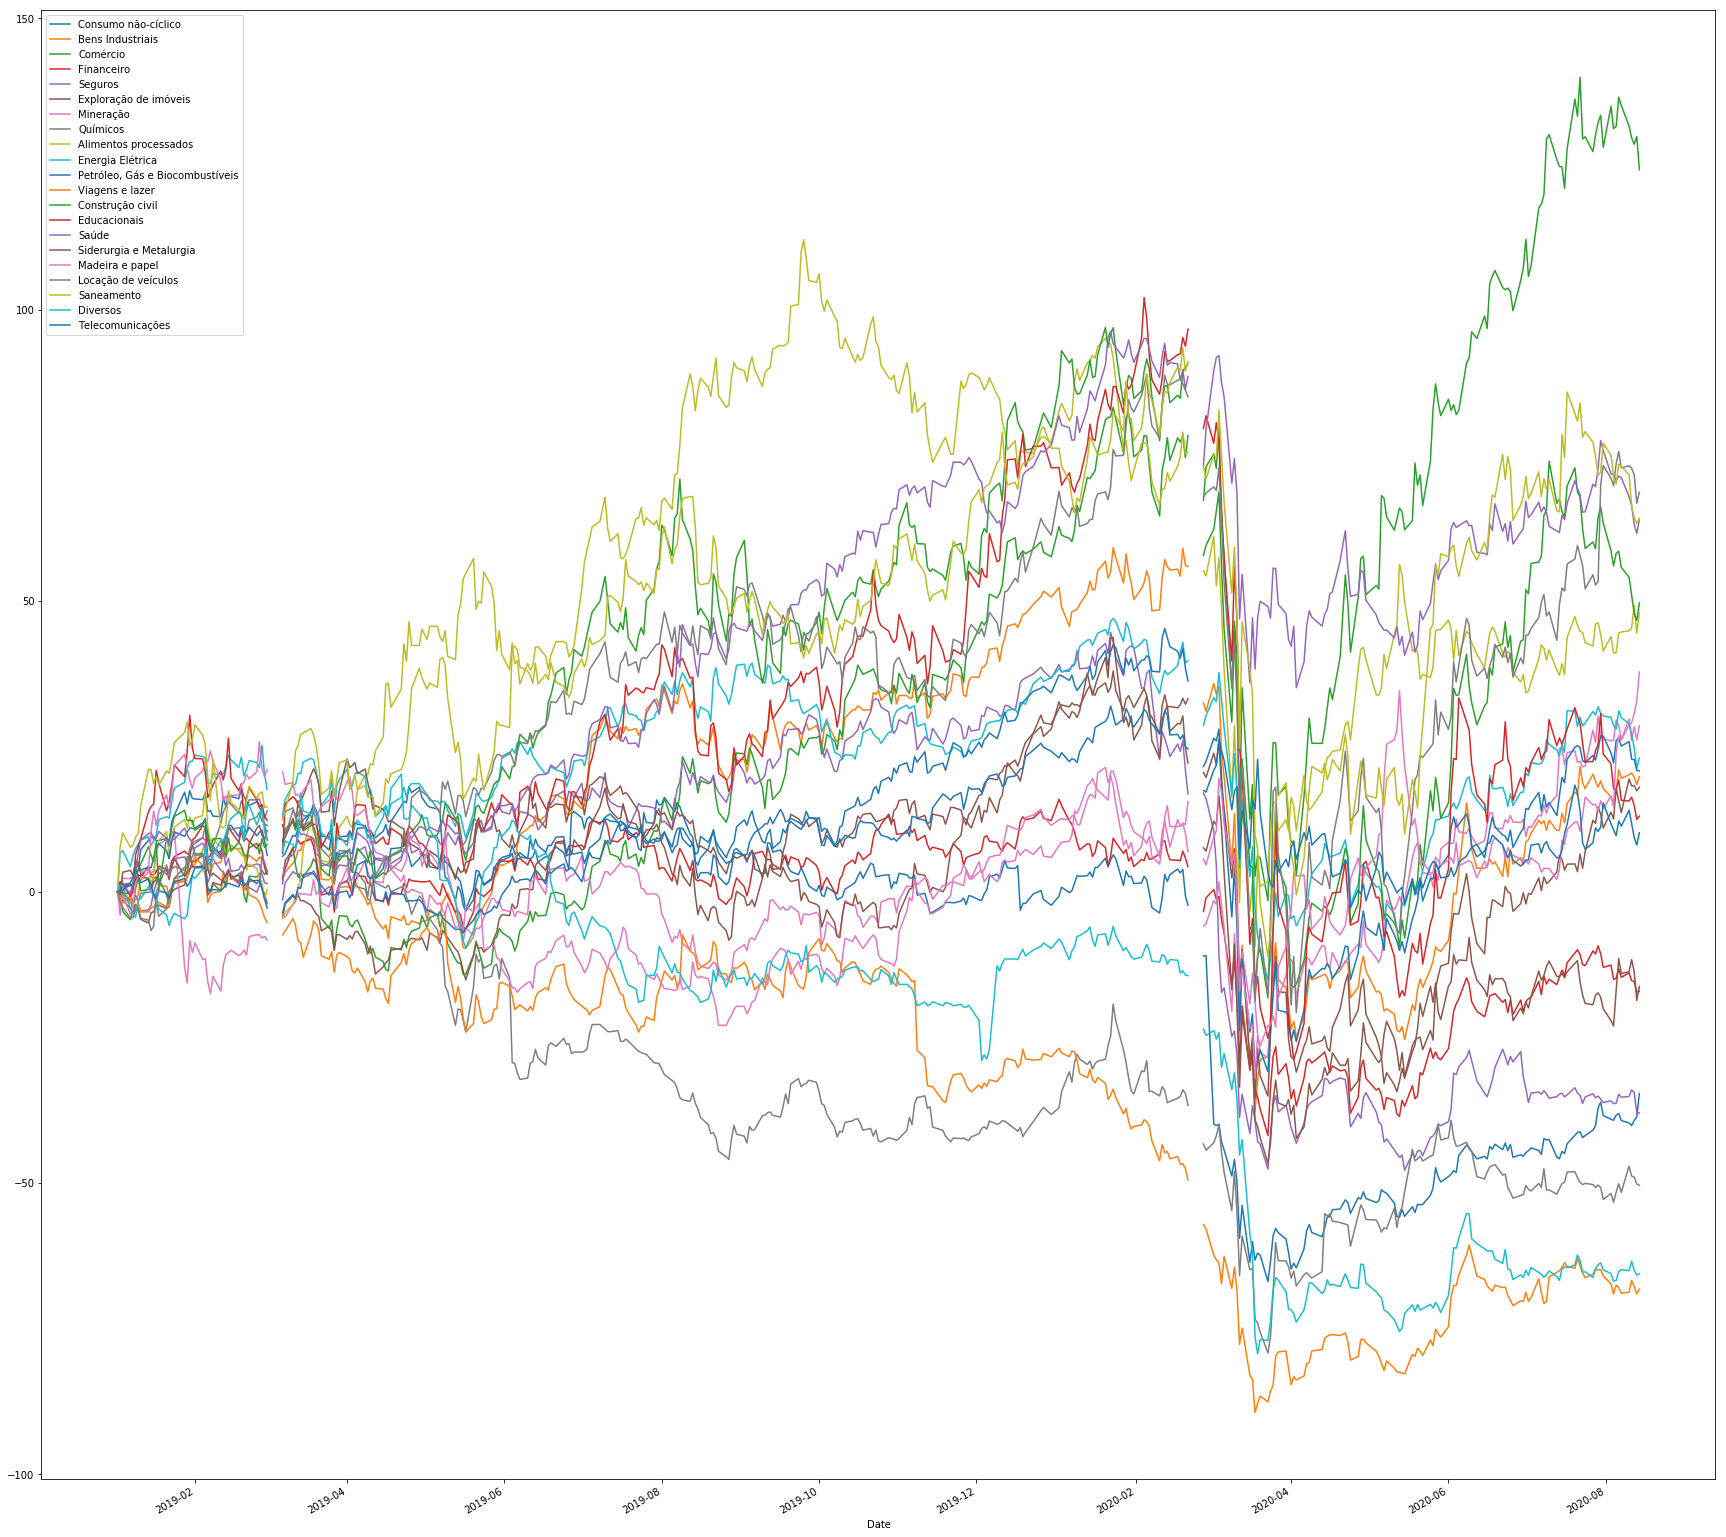

In [205]:
df_diff_categories.plot(figsize=(30,30))
#plt.plot(ibov['Close'])
# plt.plot(bova11['Close'], color='black')

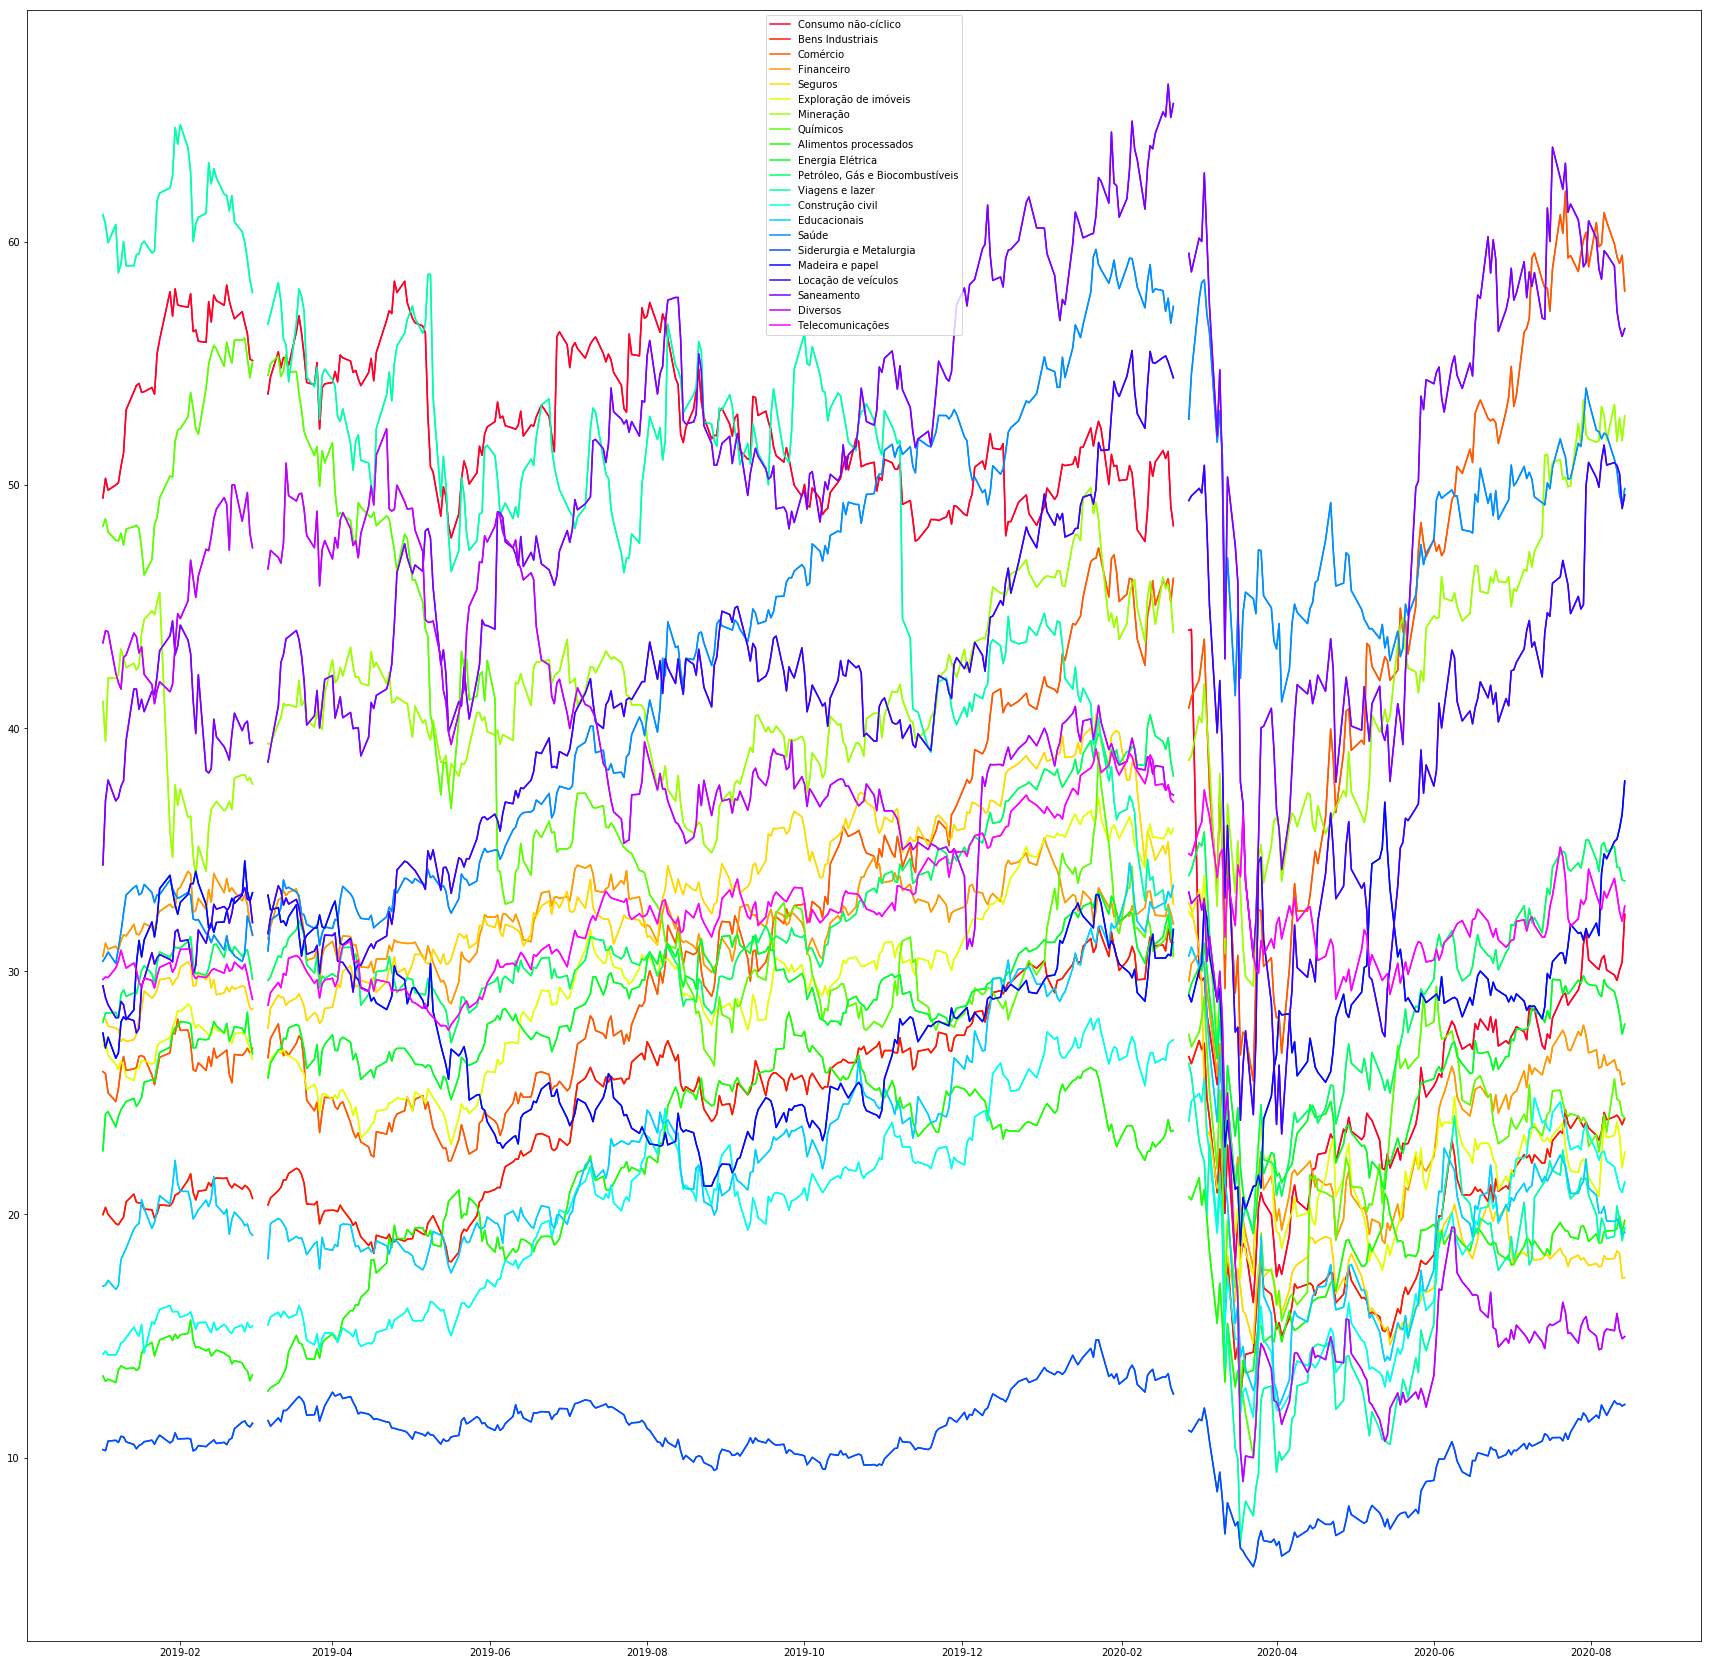

In [170]:
NUM_COLORS = len(setores.keys())

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
# Or,
# ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax.plot(df_categories)
for setor in setores.keys():
    ax.plot(df_categories[setor], label=setor)

# ax.plot(df_categories['Média'], label='Média', color='black')

# ax.plot(bova11['Close'], color='black', label='BOVA11')
    
plt.legend()
plt.show()

In [171]:
# https://app.flourish.studio/
df_categories.to_csv('categories.csv')

In [206]:
df_diff_categories.to_csv('diff_categories.csv')